<center><h1>Digital Epedemiology: Implementation of D.J. Mciver & J. S. Brownstein (2014) on Italy</h1>
<h3>Amr Elshibiny-Mohammad Khodaygani</h3></center>

### Importing the libaries used for the implementation

In [1]:
import csv
import pandas as pd
import requests
import time, datetime
from tqdm import tqdm
import numpy as np
from sklearn import preprocessing
import statsmodels as sm
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Data Gathering: 
The work for this part was divided into two parts:
* We transformed the influnet data Tables from the PDFs into CSV files in order to make it easy to process them using the tableau saoftware.
* We fetched the view counts of pages from wikipedia that are related to Influenza using the Wikipedia [API](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews). In order to build a dataset of keywords that are related to Influenza that are searched by the Italian people, three sources were used:
 1. A precompiled [file](https://github.com/geektoni/seasonal_influenza_predictor/blob/master/data/keywords/keywords_italy.txt) was found on github with around 470 keywords. However, it had a very large scope that included many other topics unrelated to Influenza. So it was filtered to around 30 keywords.
 2. We collected the links that were found on the Influenza italian wikipedia page that were about symptoms and signs or medicines that are in connection to Influenza-like dieases.
 3. A quick research on the internet for influenza and its most commonly used medicines and vaccines has enabled us to expand on the keywords for wikipedia pages for the commonly used precautions against it, both in medicines and vaccines. <br>
 **The results of all three methods were compiled together into one file with every line representing a link to an italian wikipedia page.**

In [2]:
#reading the keywords file
address = "DATA/keywords_modified.tsv"
keywords = []
with open(address, encoding='utf-8') as tsvfile: # The encoding is needed or some characters like the 208th keyword
    tsvreader = csv.reader(tsvfile, delimiter="\t")
    for line in tsvreader:
        keywords.append(line[0])

#### Making Queries to the Wikipedia API:

In [3]:
#NEW VERSION

start = time.time()

link_part_1 = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/it.wikipedia/all-access/user/"
#link_part_2 ====> is the keyword
link_part_3 =  "/daily/200101300/2018121200" 
library = {}
counter = 0
for j in tqdm(range(len(keywords))):
    keyword = keywords[j]
    link = link_part_1 + keyword + link_part_3
    r = requests.get(link)
    json_file = r.json()
    p = json_file['items']
    rrr = {}
    for item in p:
        tme = item['timestamp']
        vws = int(item['views'])

        yr = tme[0:4]
        wk = datetime.date(int(yr),int(tme[4:6]),int(tme[6:8])).strftime("%V")

        key = yr + '-' + wk

        if(key in rrr):
            rrr[key] +=vws
        else:
            rrr[key] = vws
    
    library[keyword] = list(zip(rrr.keys(),rrr.values()))


ttf = round(time.time() - start, 1)
print ('It took', ttf, 'seconds to get stat for the keywords from wikimedia, stat is accessible calling "library[keyword]"')

100%|██████████████████████████████████████████████████████████████████████████████████| 76/76 [00:20<00:00,  3.30it/s]


It took 20.7 seconds to get stat for the keywords from wikimedia, stat is accessible calling "library[keyword]"


#### Creating a dataframe from the retrieved data:

In [4]:
weeks = [i[0] for i in library[keywords[0]]]
df = pd.DataFrame(weeks)

for keyword in keywords:
    df_temp = pd.DataFrame([i[1] for i in library[keyword]])
    df = pd.concat([df, df_temp], axis=1)
df.columns = ['Week'] + keywords

# SAVING DATA TO ACCESS LATER
#df.to_csv('WIKIMEDIA_modified.csv',index=False)
wikistats = df.copy()

## Applying the baseline to the page views and putting everything together:
* We first start by applying the baseline of our choice to the wikipedia data. We chose a baseline of the italian homepage of Wikipedia. We apply this in the same way the baseline is applied in Influnet. We divide the views of each page in a given week by the number of visitors to the homepage in the same week. And then we scale up in order to have a nice Range to work with.<
* Now that we have all the data that we need together, we merge our wikipedia data with the influnet data in one dataframe. We join the data based on the week. So the data of each week gets matched together.

In [5]:
#open and concat all years influnet data..create one long dataframe with all the influnet data
gn = (i for i in os.listdir('DATA\\influnet'))
next(gn)
next(gn)
a = []
for addr in gn:
    tmp = pd.read_csv('DATA\\influnet\\'+addr)
    a.append(tmp)
influnet_all=pd.concat(a)
influnet_all.index= influnet_all['Settimana']
#influnet_all.loc['2015-27':,:]

#wikistats = pd.read_csv("WIKIMEDIA_modified.csv")
#preparing wikipedia data
wikistats.index = wikistats['Week']
wikistats = wikistats.drop(columns='Week')
#applying baseline of italian wikipedia homepage in the same method applied to influnet data: divide by baseline and then scale up by multiply by 10000
wikistats.loc[:,'Pagina_principale':]= wikistats.loc[:,'Pagina_principale':].div(wikistats.Pagina_principale,axis='index')*10000
wikistats = wikistats.drop(columns='Pagina_principale')


full_data = pd.merge(right=wikistats,left=influnet_all,left_index=True,right_index=True)
#full_data = full_data.drop(['Settimana'],axis=1)
#full_data.columns = full_data.columns[0]+['incidence_rate']+full_data.columns[2:]
tmp=tmp=[full_data.columns[0],'incidence_rate']+list(full_data.columns[2:])
full_data.columns=tmp


full_data.head()

,Settimana,incidence_rate,Influenza,Febbre,Rinorrea,Mialgia,Paracetamolo,Vaccino_antinfluenzale,Ipotalamo,Cortisolo,...,Broncopneumopatia_cronica_ostruttiva,Croup,Faringite,Faringite_streptococcica,Influenzavirus_C,Rinite,SARS,Sarcoidosi,Vaccino,Vaccino_influenza_stagionale
2015-42,2015-42,0.40,1.218149,2.897454,0.435053,0.962337,5.497331,0.497701,1.642760,2.178746,...,1.567061,0.360224,1.648851,0.639528,0.008701,0.906651,0.464637,1.590554,3.178498,0.006091
2015-43,2015-43,0.50,1.165951,2.927714,0.371829,0.867602,5.525207,0.543579,1.697135,2.176972,...,1.590013,0.367403,1.568766,0.724182,0.014165,0.972953,0.429374,1.538665,3.012703,0.003541
2015-44,2015-44,0.68,1.092939,2.808123,0.352130,0.841545,5.292643,0.607089,1.675068,2.154677,...,1.587704,0.366393,1.480728,0.800538,0.009806,0.934258,0.550927,1.431697,2.269677,0.005349
2015-45,2015-45,0.76,1.184634,2.930551,0.418524,0.911530,5.376963,0.746603,1.694488,2.483653,...,1.716656,0.336947,1.318526,0.814880,0.010640,0.927491,0.438031,1.636853,1.933011,0.002660
2015-46,2015-46,0.88,1.148216,2.731657,0.336149,0.912911,5.135126,0.795259,1.845284,2.573313,...,1.809015,0.331726,1.301252,0.921757,0.011500,0.963334,0.475917,1.578133,1.888629,0.001769


# Point 1: Comparing influnet with the Influenza wiki page
######  In order to do that, we isolate the influnet data and the Influenza page data in a seperate data frame. Afterwards, we normalize both of them, in order to have them in the same number range more or less in order to be able to compare the plots

### Normalizing data

In [6]:
x= full_data.loc[:,['Influenza','incidence_rate']].copy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalized = pd.DataFrame(x_scaled)

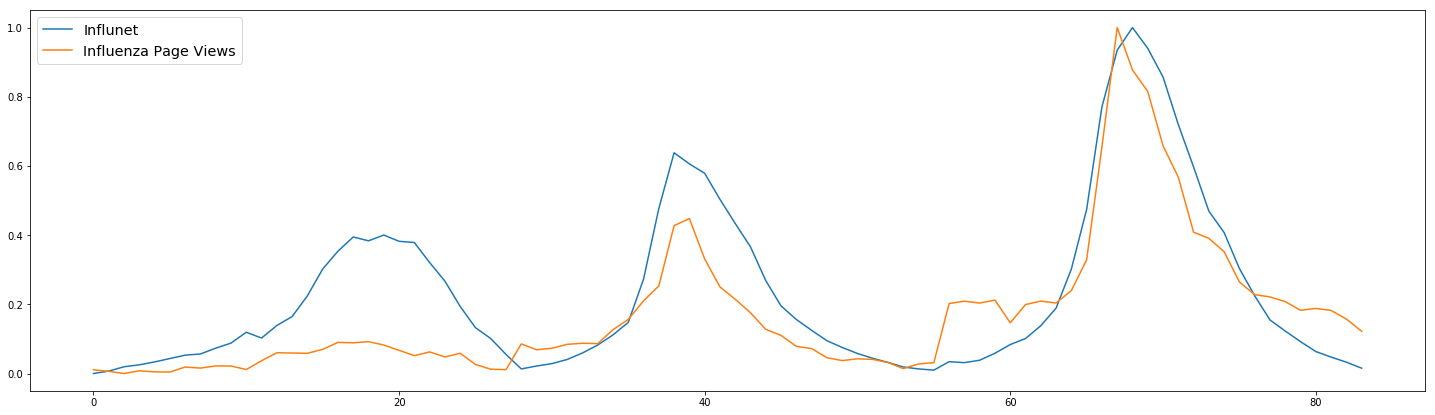

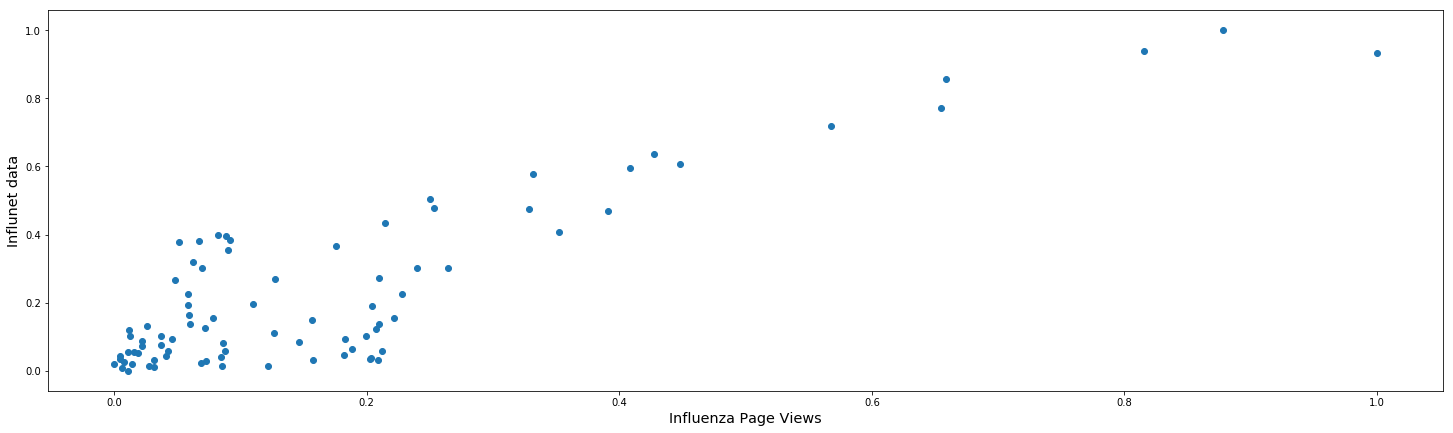

In [7]:
x_val = df_normalized.iloc[:,0]
y_val = df_normalized.iloc[:,1]

plt.rcParams["figure.figsize"] = (25,7)
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['legend.fontsize']= 'x-large'

plt.plot(y_val)
plt.plot(x_val)
plt.legend(['Influnet','Influenza Page Views'],loc='upper left')
plt.show()

plt.scatter(x_val,y_val)
plt.xlabel('Influenza Page Views')
plt.ylabel('Influnet data')
plt.show()

In [8]:
cor = df_normalized.corr(method='pearson', min_periods=1)
print('The pearson coefficient correlation between the influenza page views and influnet data is',cor.loc[0,1])

The pearson coefficient correlation between the influenza page views and influnet data is 0.8585840384740604


## Point 1 Conclusion:
*As we can see from the plots and the correlation coefficient between the wikipedia data and the official influenza data, there is definitely an undeniable link between the two forms of data. This can indeed be a resource that can be used to help predict the dynamichs of the flu wave that comes with winter every year, especially that unlike the official Influnet data, the wikipedia is updated in real time whereas the official one takes up a delay of up to 2 weeks. <br>In the next section, we try to capitalize on that and see if we can make a useful model out of it.*
# Point 2:
In this section we study the relation between Influnet data and more page views of different related wikipedia pages. Since, our data is huge and we can't possibly plot the page views of each page and discuss its relation to Influnet, we chose a bunch of pages that we expect to be closely related to influenza.

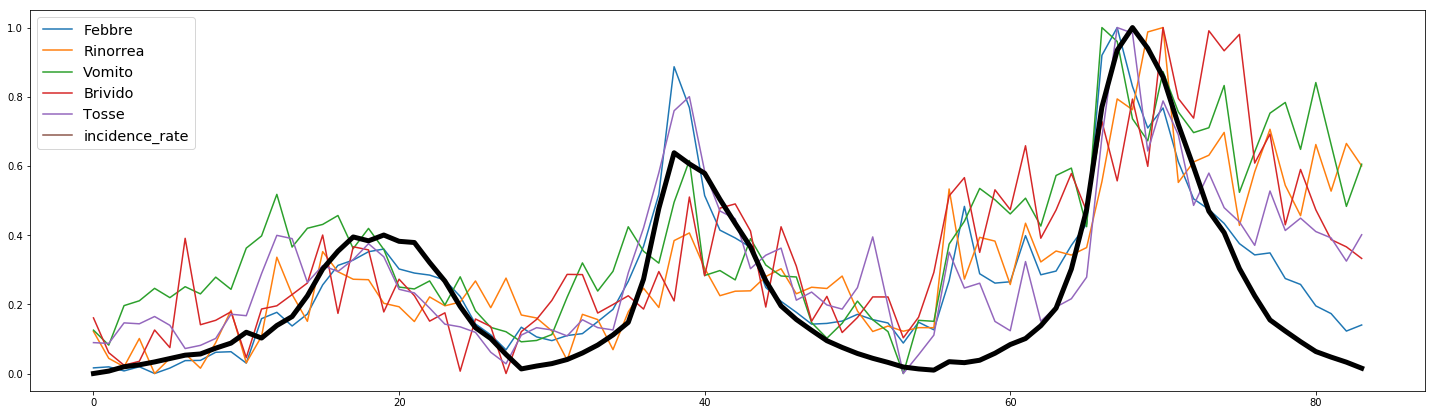

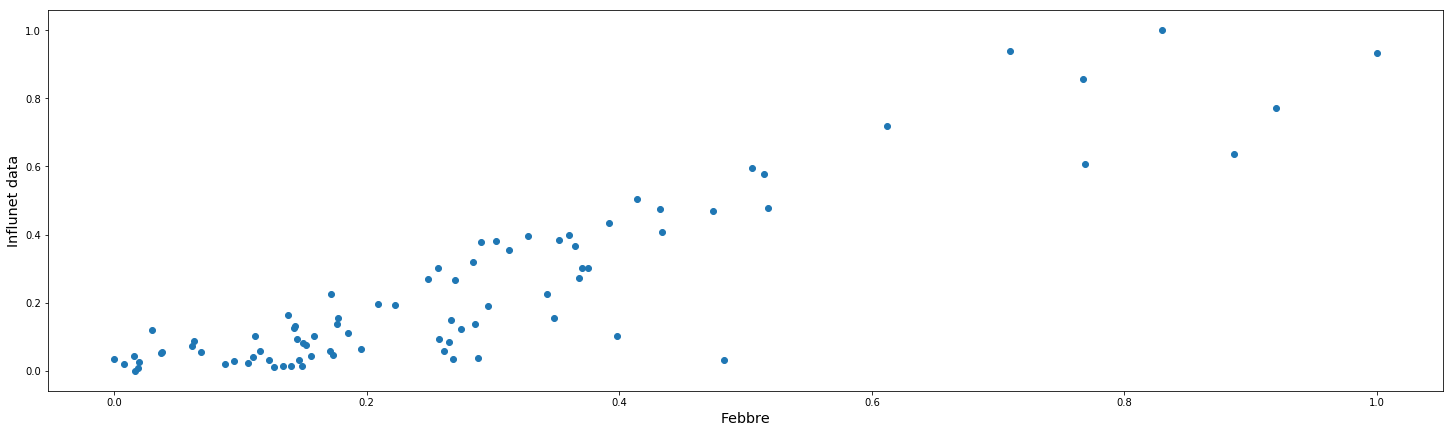

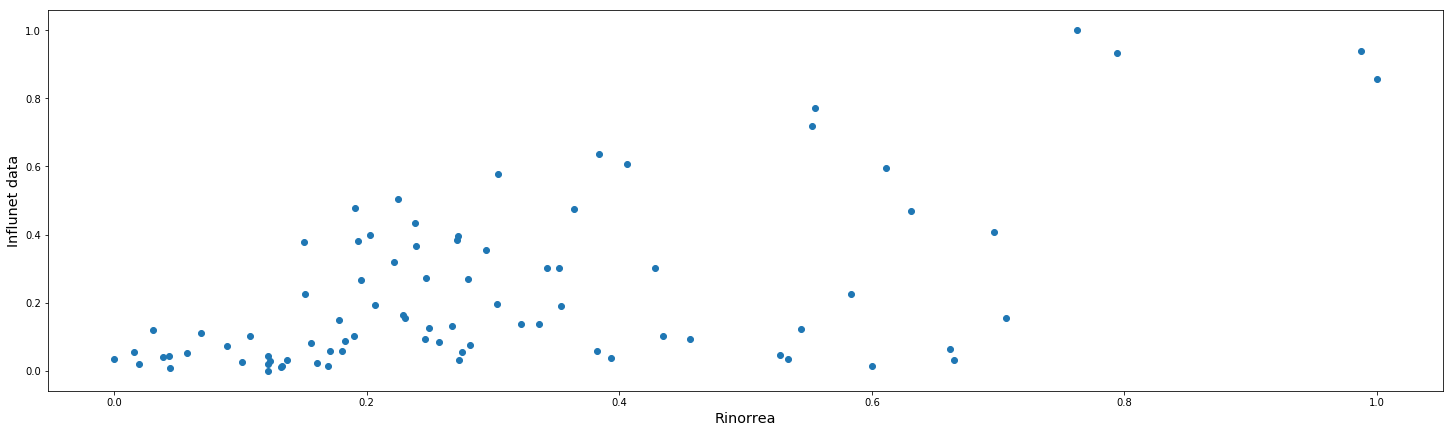

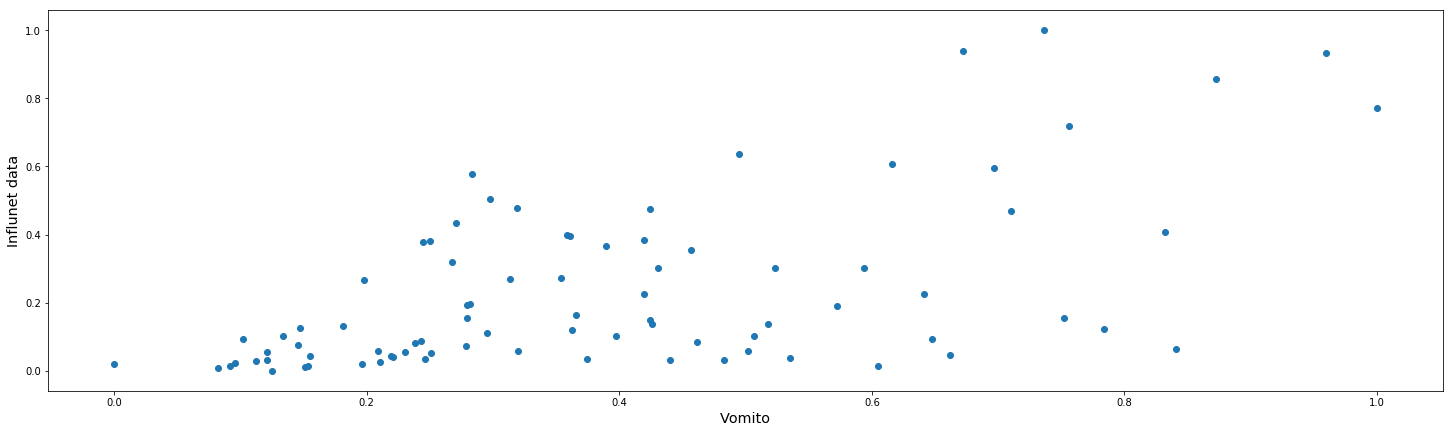

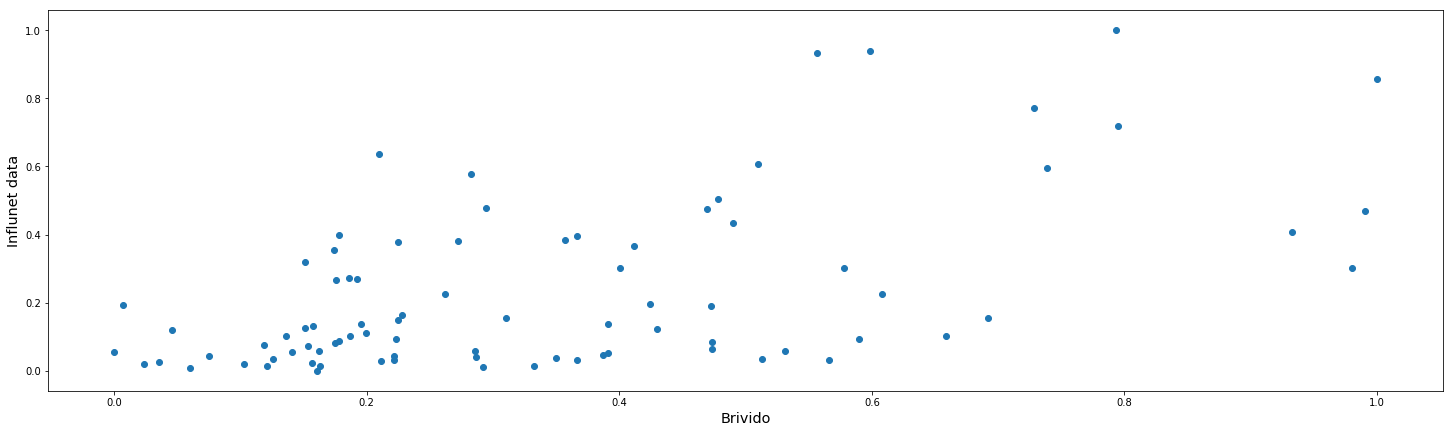

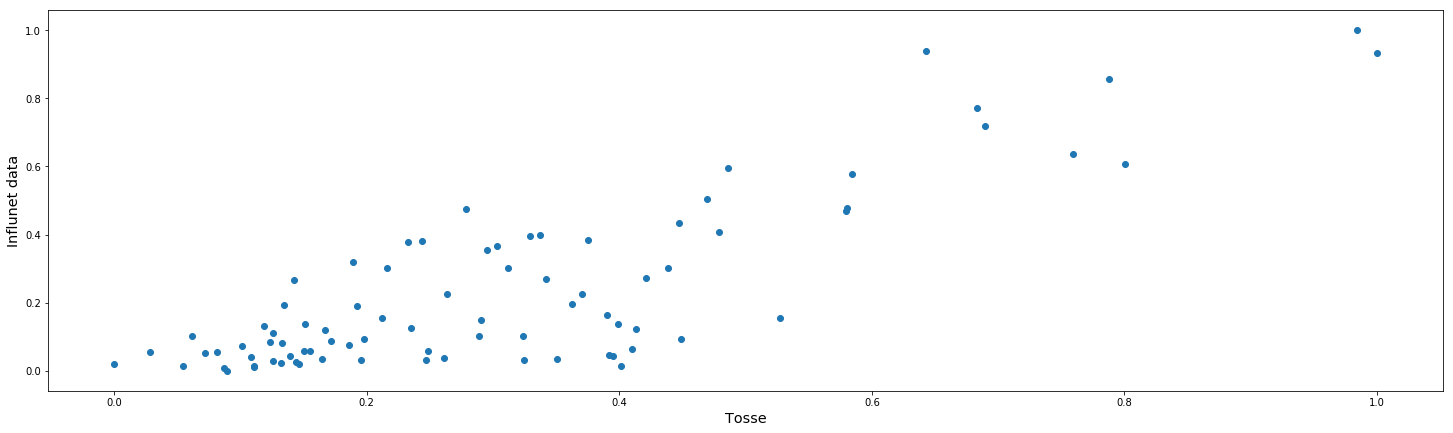

In [9]:
chosen_keywords = ['Febbre','Rinorrea','Vomito', 'Brivido','Tosse']
#chosen_keywords = ['Febbre']
chosen_keywords.append('incidence_rate')

df = full_data.loc[:,chosen_keywords].copy()
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(x_scaled)
df_normalized.columns = chosen_keywords

for k in chosen_keywords:
    plt.plot(df_normalized[k])
    if k == 'incidence_rate':
        plt.plot(df_normalized[k],linewidth=5,color='black')
    
plt.legend(chosen_keywords,loc='upper left')
plt.show()

y_val = df_normalized['incidence_rate']
for k in chosen_keywords[:-1]:
    x_val=df_normalized[k]
    plt.scatter(x_val,y_val)
    plt.xlabel(k)
    plt.ylabel('Influnet data')
    plt.show()

#### Testing Correlation between Influnet and the various page views

In [10]:
corr_matr = df_normalized.corr(method='pearson',min_periods=1)
pd.DataFrame(corr_matr['incidence_rate']).transpose()

,Febbre,Rinorrea,Vomito,Brivido,Tosse,incidence_rate
incidence_rate,0.899862,0.599041,0.58231,0.558981,0.82952,1.0


## Point 2 Conclusion:
*From looking at some of the wikipedia page views of some of the keywords associated with flu and Influenza, we can see that there is definitely a positive correlation between the page views and the real data.<br><br>There has been found a very strong correlation between the Influent data and the wikipedia page views of Febbre. It is even more strong than the correlation between Influnet and the Influenza page. This makes sense since people in general tend more to search for their symptoms than searching the actual disease.<br><br>Generally, the data oscilates within the same range, but it seems to be sometimes loosely correlated. This can be fixed by aggregating many of the pageviews together in order to come up with a robust way of predicting the curve of Influenza incidence rates at a fairly high accuracy while limiting the effects of outliers. <br> Next we try to use Data science techniques and machine learning that we can train using the data we have and see how it performs.*

# Point 3.1:
As a first step, we split our data into training and testing data. We pick the data of the wave of 2017-2018 as test data for our model of choice and all the previous years are used to train the model.

In [47]:
years = [int(idx[:4]) for idx in full_data.index]
weeks = [int(idx[-2:]) for idx in full_data.index]
full_data['years'] = years
full_data['weeks']= weeks
#full_data = full_data.drop(columns='Settimana')

x_train,x_test,y_train,y_test = train_test_split(full_data.iloc[:,1:],full_data['incidence_rate'],test_size=1/3,random_state=0)

data2018 = full_data.loc['2017-42':,:].iloc[:-1,:]



## Basic Linear Regression:
As a first step we try to train a simple linear regressor and see how it performs on the test data

In [46]:
data2018

,incidence_rate,Influenza,Febbre,Rinorrea,Mialgia,Paracetamolo,Vaccino_antinfluenzale,Ipotalamo,Cortisolo,Prostaglandine,...,Faringite,Faringite_streptococcica,Influenzavirus_C,Rinite,SARS,Sarcoidosi,Vaccino,Vaccino_influenza_stagionale,years,weeks
2017-42,0.89,3.461545,5.468494,0.770543,1.275720,13.808832,0.744989,4.110216,4.719574,3.304291,...,2.187791,1.814313,0.021622,1.957807,1.218715,5.226716,5.533361,0.007863,2017,42
2017-43,0.85,3.540574,7.658541,0.558336,1.206234,12.275770,1.179556,4.239924,4.729659,3.087046,...,2.166649,1.838888,0.009528,1.770287,0.968037,4.870672,5.055513,0.007622,2017,43
2017-44,0.95,3.478065,5.672255,0.656684,1.336961,13.707785,0.985026,4.046274,4.323497,3.265724,...,2.270868,1.924831,0.011797,1.749846,1.303537,4.612516,4.877942,0.000000,2017,44
2017-45,1.24,3.577061,5.396936,0.647784,1.286070,12.684034,2.076329,4.859332,4.654169,3.337704,...,2.800100,1.941453,0.015197,1.778082,1.261375,5.700882,5.826259,0.007599,2017,45
2017-46,1.60,2.809001,5.436161,0.545521,1.212269,11.784988,1.993317,4.320874,4.566791,3.174413,...,2.308507,1.956949,0.020782,1.711031,1.040820,5.164267,5.330521,0.001732,2017,46
2017-47,1.85,3.425748,6.795824,0.689921,1.334113,14.124499,1.962399,4.568989,5.163475,3.737902,...,3.630537,2.248706,0.019882,1.996199,1.264524,6.093974,6.026373,0.001988,2017,47
2017-48,2.38,3.544674,5.642307,0.598775,1.253206,13.631736,1.665824,4.577177,4.700003,3.281750,...,3.251043,2.212782,0.013434,1.951777,1.333811,5.089591,4.982118,0.003838,2017,48
2017-49,3.11,3.479117,5.751897,0.624457,1.370561,14.240861,1.338122,4.065052,4.691537,3.272316,...,3.454787,2.076116,0.018247,1.928112,1.295545,4.803047,4.472571,0.006082,2017,49
2017-50,4.73,3.898814,6.510323,0.614955,1.250408,16.946109,1.125368,4.726954,4.960637,3.863967,...,3.839369,2.021152,0.024598,2.301981,1.221711,4.835596,4.790499,0.004100,2017,50
2017-51,7.20,4.941428,7.139309,0.632625,1.271771,18.335241,0.750019,3.732702,4.260976,2.830506,...,3.834878,2.317449,0.008696,2.276144,0.919588,4.793598,3.491392,0.002174,2017,51


In [48]:
#basic linear regression
regr = linear_model.LinearRegression()
#regr.fit(train_data.drop(columns=['incidence_rate']),train_data['incidence_rate'])
regr.fit(x_train,y_train)
regr_predicted = regr.predict(data2018.drop(columns=['incidence_rate']))

print('MSE\t\t\t  R^2')
print(mean_squared_error(regr_predicted , data2018['incidence_rate']),'\t',r2_score(y_pred=regr_predicted,y_true=data2018['incidence_rate']))


MSE			  R^2
0.6942556899166153 	 0.9675834359278119


#### Plotting the result:

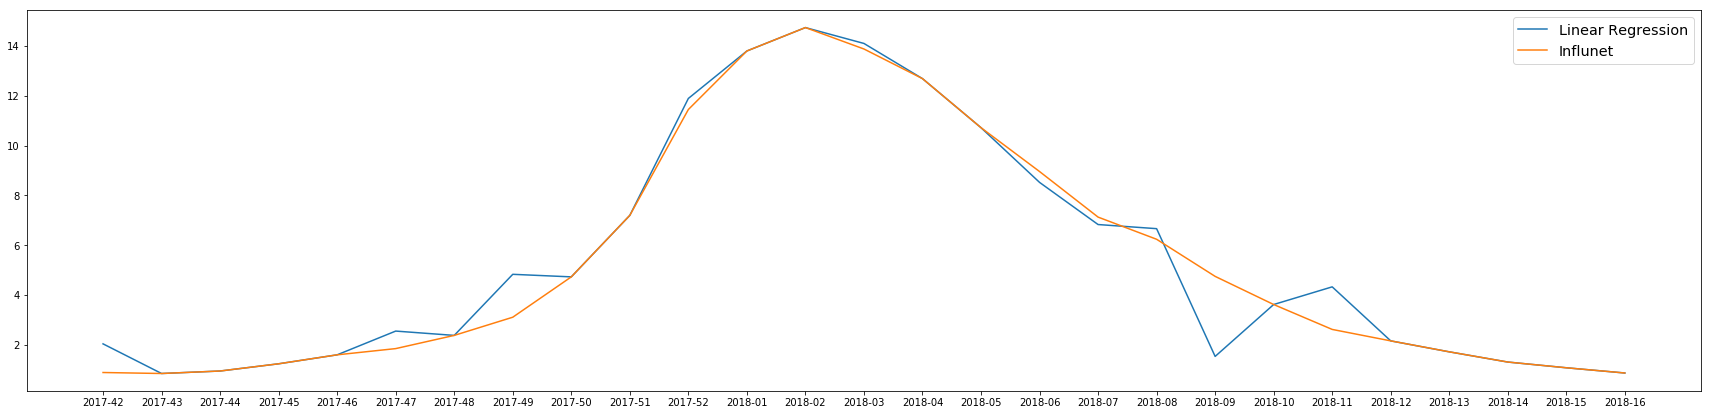

In [50]:
plt.rcParams["figure.figsize"] = (30,7)
plt.rcParams['axes.labelsize'] = 'x-large'
plt.rcParams['legend.fontsize']= 'x-large'

plt.plot(regr_predicted)
plt.plot(data2018['incidence_rate'])
plt.legend(['Linear Regression', 'Influnet'], loc='upper right')

plt.show()

As we can see from the plot, the predictions more or less follow the same patterns of the influnet data. however, its errors are completely within unacceptable ranges. this requires us to fine tune our model until the data we have is well fitted. To do this, we add regularization to our model through a Lasso regression model.
## Lasso model:
We create a regularized lasso regression model where the regularization term alpha is chosen as a hyperparamter. In order to choose the best value of alpha, do a grid search and compare between the different values of alpha based on the models' results of MSE and Rsquared:

In [51]:
alphasl =np.arange(.00001,.0004, .00001)
R2s=np.zeros(len(alphasl))
MSEs = np.zeros(len(alphasl))
print('MSE\t\t\t R^2\t\t\talpha')
for i in range(len(alphasl)):
    lass = linear_model.Lasso(normalize=0,alpha=alphasl[i],max_iter=10**6)
    lass.fit(x_train,y_train)
    lasso_pred= lass.predict(data2018.drop(columns=['incidence_rate']))
    MSEs[i] = mean_squared_error(lasso_pred,data2018['incidence_rate'])
    R2s[i]=r2_score(lasso_pred,data2018['incidence_rate'])
    print(MSEs[i],'\t',R2s[i],'\t',round(alphasl[i],5))
    
    #pd.DataFrame([lasso_pred,test_data['incidence_rate']])

MSE			 R^2			alpha
1.1143980957753818 	 0.9517686864180913 	 1e-05
0.8963565694985084 	 0.9559027978042846 	 2e-05
0.6122625540235163 	 0.968183729150631 	 3e-05
0.5547388073009566 	 0.9724273245220841 	 4e-05
0.5521148803262046 	 0.9725426086445337 	 5e-05
0.586251145669718 	 0.970335836146662 	 6e-05
0.5783527242632766 	 0.9707091836301077 	 7e-05
0.5712105145889387 	 0.9710538291834467 	 8e-05
0.5755526043890711 	 0.9706788948562279 	 9e-05
0.6242121769763537 	 0.967723222459342 	 0.0001
0.6237970984417436 	 0.9677795766081911 	 0.00011
0.6220569161948414 	 0.9679120816177428 	 0.00012
0.6135092590902943 	 0.9684743260414311 	 0.00013
0.6070558528786267 	 0.9689268075259888 	 0.00014
0.6049539936204446 	 0.9690896404519844 	 0.00015
0.6051090753856398 	 0.9690981706305243 	 0.00016
0.6143582836190039 	 0.9685323319931488 	 0.00017
0.617397413185201 	 0.9683704937742883 	 0.00018
0.6160184872271713 	 0.9684802516557001 	 0.00019
0.6148710486406233 	 0.9685787036244001 	 0.0002
0.6139

##### Next we plot the curves of both MSE and R^2 over alpha to observe its properties:

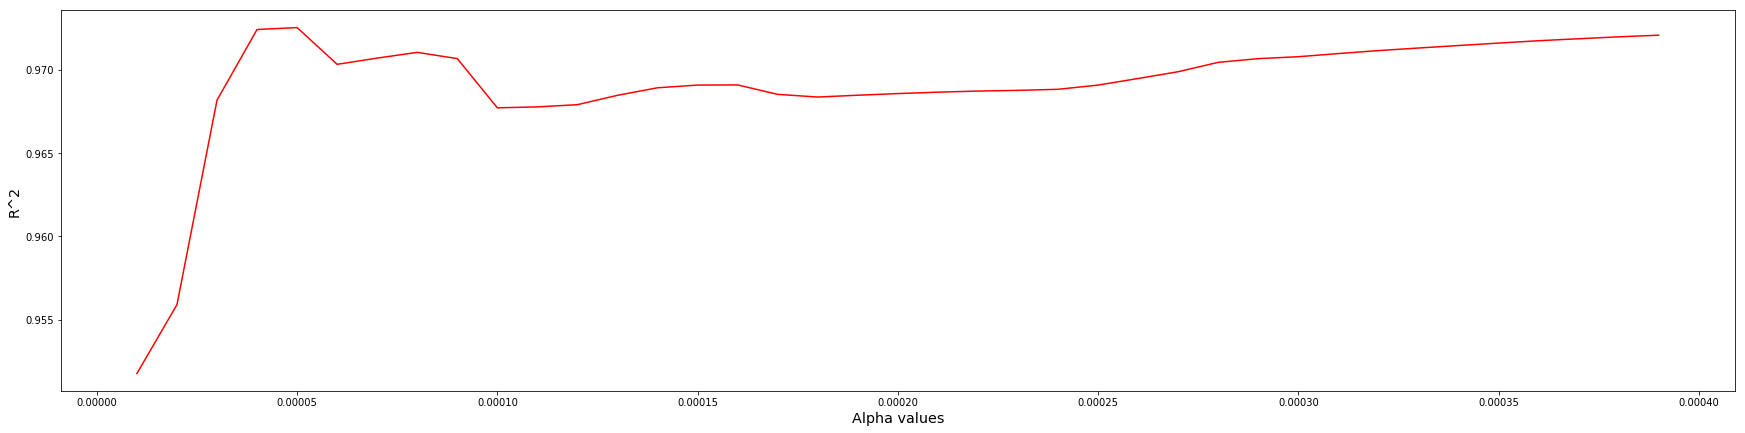

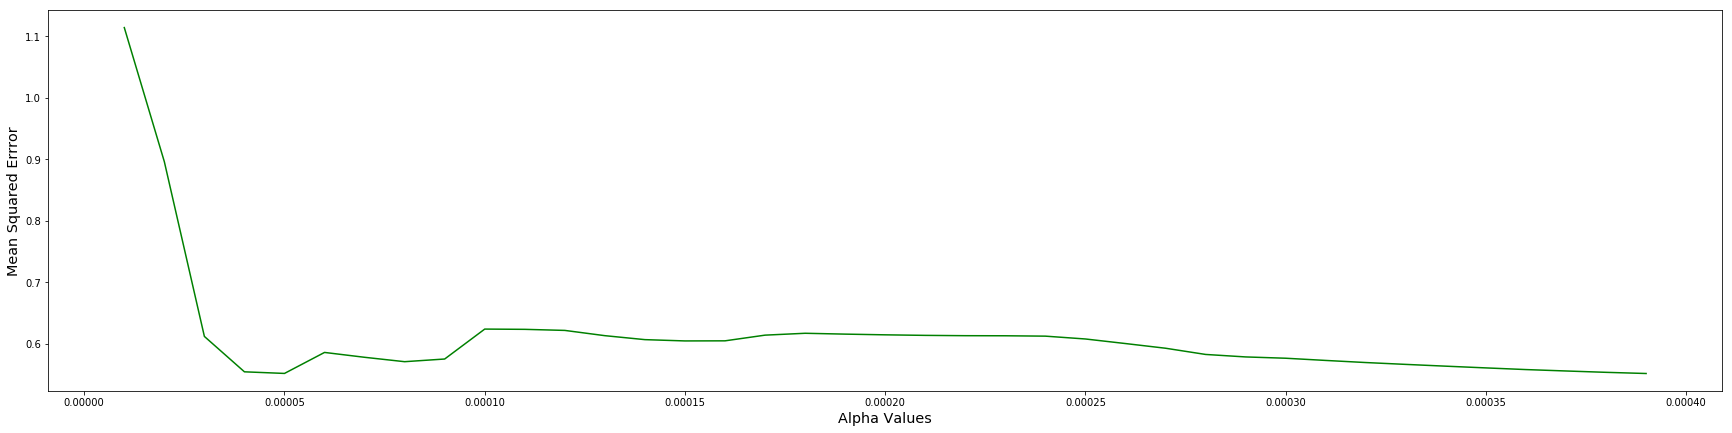

In [52]:
plt.plot(alphasl,R2s,color='red')
plt.xlabel('Alpha values')
plt.ylabel('R^2')

plt.figure()
plt.plot(alphasl,MSEs,color='green')
plt.xlabel('Alpha Values')
plt.ylabel('Mean Squared Errror')
plt.show()

**From observing both the graph and the table of the properties of alpha, we see that the best value of alpha which maximizes R^2 and minimizes MSE is .027. We build our graph using the optimal alpha and plot the prediction results:**

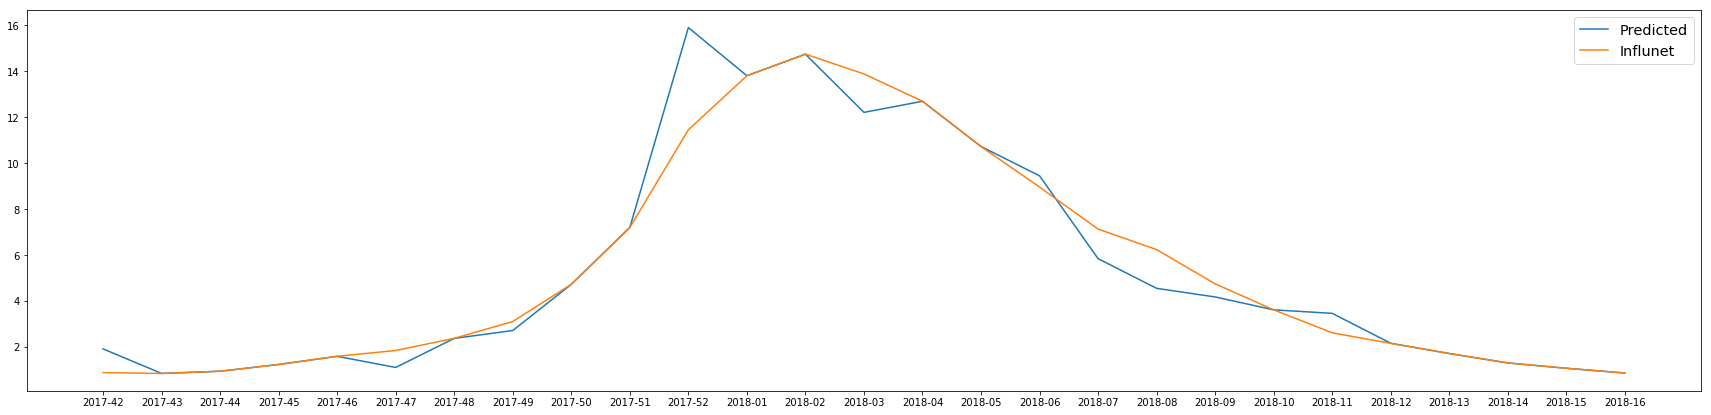

In [53]:
lass = linear_model.Lasso(normalize=False,alpha=.00001,max_iter=10**6)
lass.fit(x_train,y_train)
lasso_pred= lass.predict(data2018.drop(columns=['incidence_rate']))
    
plt.plot(np.abs(lasso_pred))
plt.plot(data2018['incidence_rate'])
plt.legend(['Predicted', 'Influnet'], loc='upper right')
plt.show()

We notice that we have a great improvement over the previous model. However, There are still imperfections that are related to predicting the peak and also related to the predictions at the beginning of the flu wave. We try to improve these aspects by applying corss validation.
## Lasso with Cross valiadation:
Next, we try to improve even more on the result we have achieved by applying cross validation techniques to our model and checking if it makes a signigicant improvement over the results we got:

MSE			 R^2			alpha
1.1143980957753818 	 0.9517686864180913 	 .03


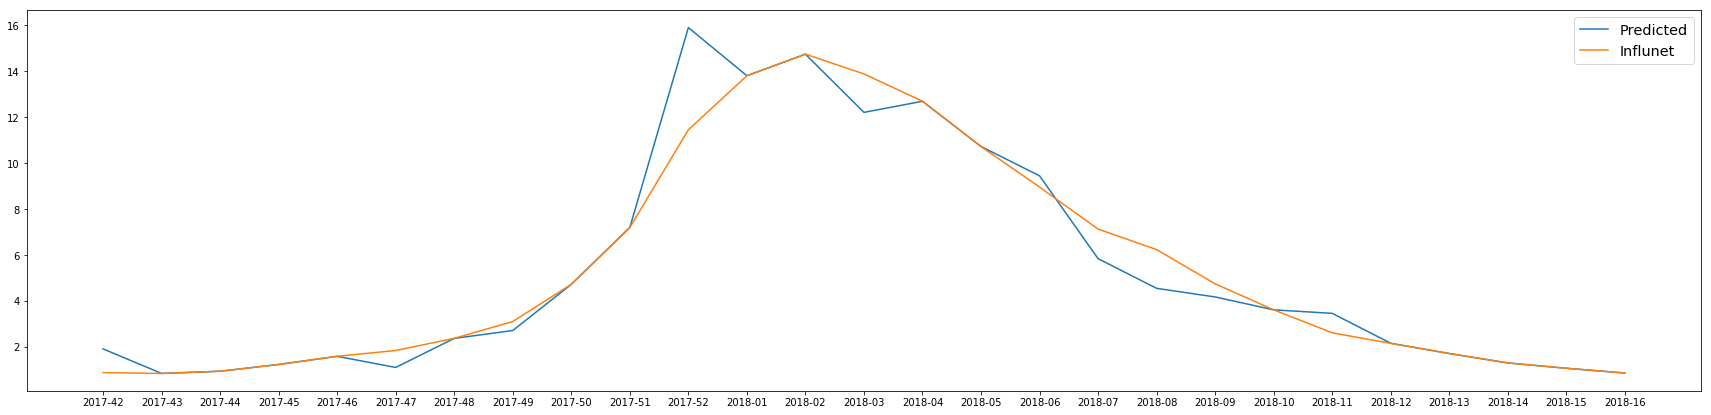

In [54]:
cvlasso = linear_model.LassoCV(alphas=[.00001],cv=10,max_iter=10**6)
cvlasso.fit(x_train,y_train)
cvlasso_pred= cvlasso.predict(data2018.drop(columns=['incidence_rate']))

print('MSE\t\t\t R^2\t\t\talpha')
print(mean_squared_error(cvlasso_pred,data2018['incidence_rate']),'\t',r2_score(cvlasso_pred,data2018['incidence_rate']),'\t','.03')

plt.plot(np.abs(cvlasso_pred))
plt.plot(data2018['incidence_rate'])
plt.legend(['Predicted', 'Influnet'], loc='upper right')
plt.show()

We notice that we have reached an exact result to the model that was without prediction. This tells us that once we have reached the optimal alpha, improving on it using cross validation can't be done.
Next we try to use lasso again, but this time, we turn on the option of normalizing the whole dataset. Lasso is not known to perform much better with normalization when the ranges of the numbers are not generally high. But we will give it a chance and see if it leads to better results.

## Lasso with normalization:
We redo the same things we did with the model, but this time, normalization is turned on


MSE			 R^2			alpha
0.6730414682446166 	 0.9651631184981672 	 0.001
0.8739318937374826 	 0.9540178085785455 	 0.002
1.0693895913708376 	 0.9431555114795815 	 0.003
1.1239003044762859 	 0.9397489308143926 	 0.004
1.1882602655105141 	 0.9358063361460944 	 0.005
1.195312933850546 	 0.9350502721283019 	 0.006
1.2084930079756786 	 0.9335511958902952 	 0.007
1.2491676906648606 	 0.9303243340317567 	 0.008
1.2996892386496688 	 0.9264323110784731 	 0.009
1.3462081790439033 	 0.92257959391977 	 0.01
1.3952682107632044 	 0.9184888258067079 	 0.011
1.4452270592367196 	 0.9142095237102279 	 0.012
1.5000128035267304 	 0.9095200822956206 	 0.013
1.5343157613401681 	 0.9059472270844741 	 0.014
1.5730215716173814 	 0.9020142060192801 	 0.015
1.6042854137565215 	 0.8986277023683279 	 0.016
1.6248064835260694 	 0.8960285912294413 	 0.017
1.6498240607274126 	 0.893103348122733 	 0.018
1.679358044059289 	 0.889839691213334 	 0.019
1.713123474438312 	 0.8862433271565042 	 0.02
1.7549785810518523 	 0.8821159

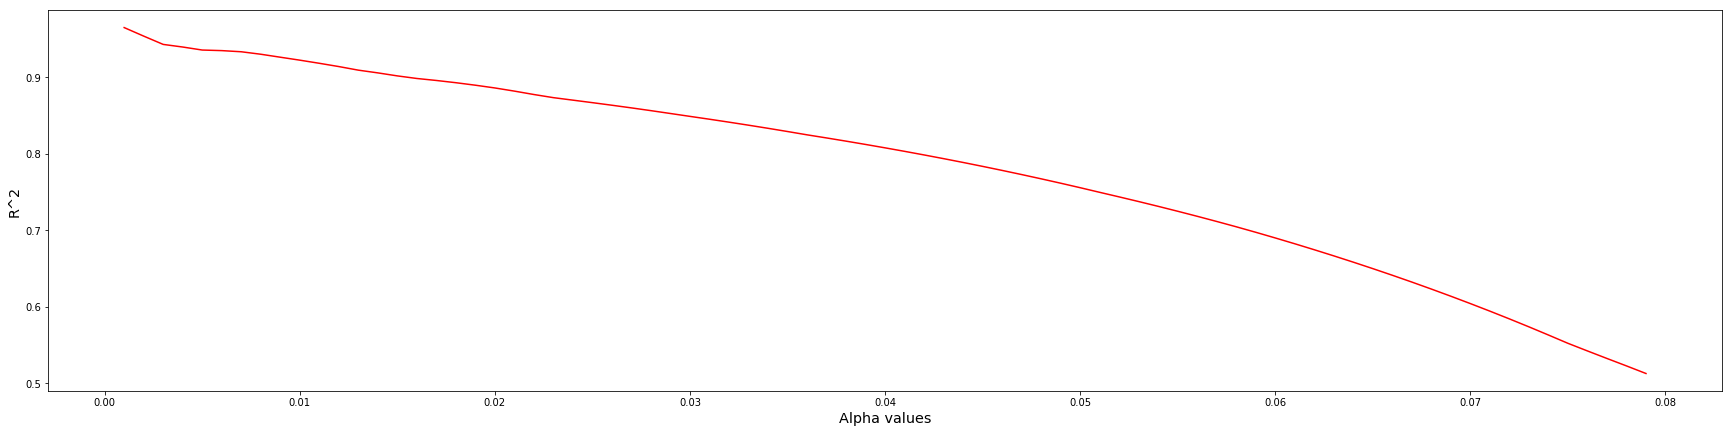

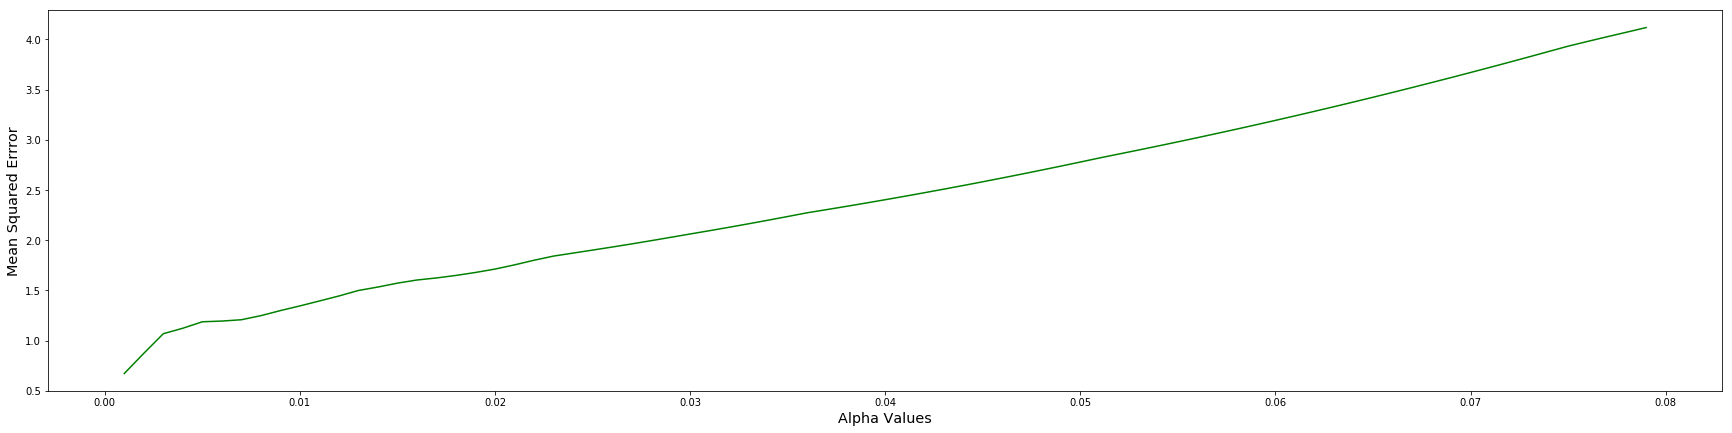

In [55]:
alphasl =np.arange(.001,.08, .001)
R2s=np.zeros(len(alphasl))
MSEs = np.zeros(len(alphasl))
print('MSE\t\t\t R^2\t\t\talpha')
for i in range(len(alphasl)):
    lass = linear_model.Lasso(normalize=1,alpha=alphasl[i],max_iter=10**6)
    lass.fit(x_train,y_train)
    lasso_pred= lass.predict(data2018.drop(columns=['incidence_rate']))
    MSEs[i] = mean_squared_error(lasso_pred,data2018['incidence_rate'])
    R2s[i]=r2_score(lasso_pred,data2018['incidence_rate'])
    print(MSEs[i],'\t',R2s[i],'\t',round(alphasl[i],5))
    
    #pd.DataFrame([lasso_pred,test_data['incidence_rate']])

plt.plot(alphasl,R2s,color='red')
plt.xlabel('Alpha values')
plt.ylabel('R^2')

plt.figure()
plt.plot(alphasl,MSEs,color='green')
plt.xlabel('Alpha Values')
plt.ylabel('Mean Squared Errror')
plt.show()

This time we notice that things are generally a lot more promissing of better curve fits. However, this time it's a bit more complicated with the minimum of MSE not coinciding with the maximum of R^2. We have decided to use both values of alpha and see how they work out with respect to our Influnet data

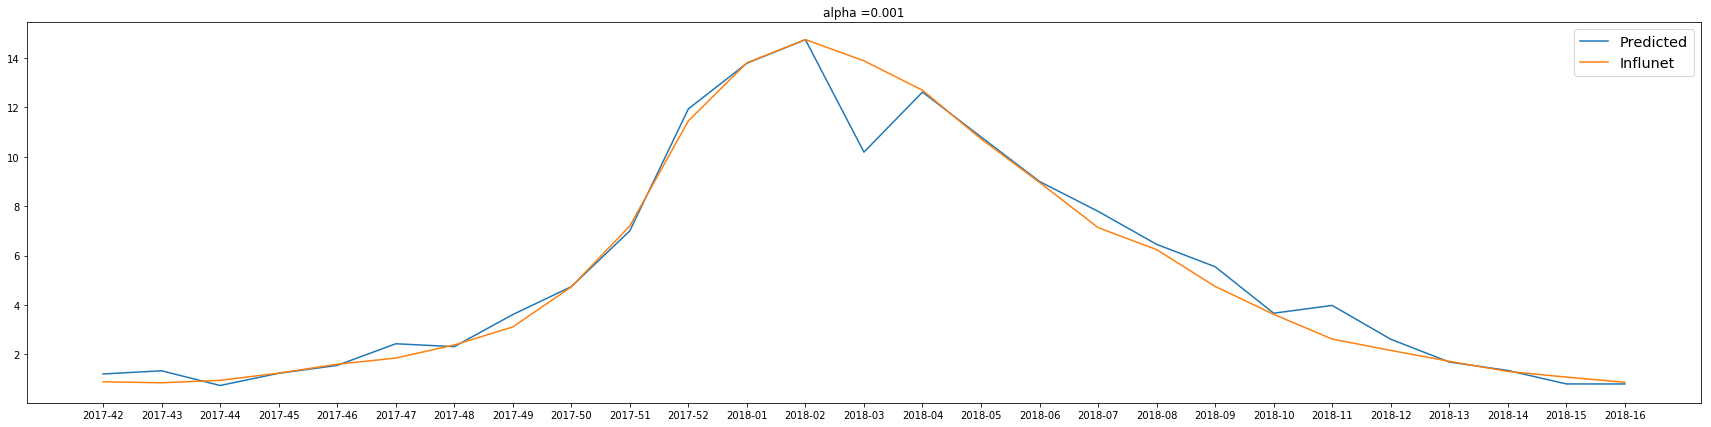

In [56]:
#alphas = [.0004,.00013]
alphas = [.001]
for alpha in alphas:
    lass = linear_model.Lasso(normalize=1,alpha=alpha,max_iter=10**6)
    lass.fit(x_train,y_train)
    lasso_pred= lass.predict(data2018.drop(columns=['incidence_rate']))

    plt.plot(np.abs(lasso_pred))
    plt.plot(data2018['incidence_rate'])
    plt.legend(['Predicted', 'Influnet'], loc='upper right')
    titl = 'alpha ='+str(alpha)
    plt.title(titl)
    plt.show()


The model seems to be performing generally much better and well fitted in the case of normalized data, with not much discernible difference between the performance of our two optimal alpha values. But we can definitely see a much better result now.

## Conclusion on model fitting:
*Lasso model seems to create a model that behaves fairly well. Once we reach our optimal value of alpha, Cross validation doesn't seem to have an effect on the result. however, normalizing the dataset seems to produce a more accurate fit for our model.*
# Point 3.2
Now, We try to build the same optimal model that we did for point 3.1. however, this time for each week that we pass, we predict its value and then we train the model on the real value of that week. <br> So for each week that we predict, the model will have been trained for all the preceeding weeks. This is expected to lead to generally a lot better performance since the training phase is extended to include the same years data, sequentially.

MSE			 R^2
0.5328708580520444 	 0.972626423210391


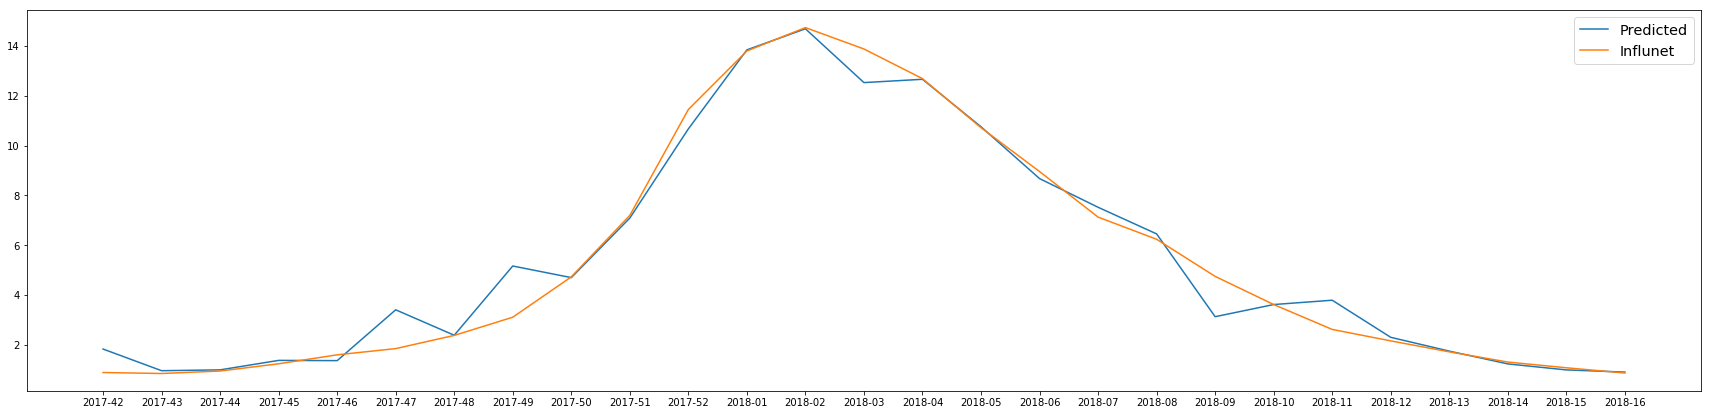

In [57]:
#3.2
lasso = linear_model.Lasso(normalize=0,alpha=.001,max_iter=10**6)
lasso.fit(x_train,y_train)
pred1 = np.zeros(len(data2018))
for i in range(len(data2018)):
    datapoint = data2018.iloc[i,:] 
    datapoint=pd.DataFrame(datapoint).transpose()
    pred1[i]=np.abs(lasso.predict(datapoint.drop(columns=['incidence_rate'])))
    lass.fit(datapoint.drop(columns=['incidence_rate']),datapoint['incidence_rate'])
    #print(i,len(test_data))
print('MSE\t\t\t R^2')
print(mean_squared_error(pred1,data2018['incidence_rate']),'\t',r2_score(pred1,data2018['incidence_rate']))

plt.plot(pred1)
plt.plot(data2018['incidence_rate'])
plt.legend(['Predicted', 'Influnet'], loc='upper right')
plt.show()

## Conclusions on real time training:
*This method has led to an incredible result when it came to smoothing our fit of the model and making it behave nicely and robustly.*
# Conclusions: 
**Generally, there seems to be a lot of potential in trying to model the flu spread on Wikipedia's page views. The current results seem to be affected by the fact that there was not much correlation in previous years. However, it has been noticed that the correlation between wikipedia searches and the flu wave has gotten closer over the recent years. If this trend persists, we think it will definitely be possible to build even more reliable models that can help us predict the flu rates in real time and with a very high reliability. **